In [1]:
import os
import sys
import time
import warnings
import sklearn
import random
import shutil
import numpy as npy 
import pandas as pds 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen

2025-05-09 08:56:37.131355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746780997.308669      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746780997.359825      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ROOT = '/kaggle/input'
DATASET_NAME = 'keratoconus-detection'

TRAIN_PATH = os.path.join(ROOT, DATASET_NAME, 'Train_Validation sets', 'Train_Validation sets')
TEST_PATH = os.path.join(ROOT, DATASET_NAME, 'Independent Test Set', 'Independent Test Set')

train_kcn_img_path = os.path.join(TRAIN_PATH, 'Keratoconus')

MODEL_PATH = 'models'
IMAGE_PATH = 'images'
MOD_DATA = '../mod_data'
MOD_DATA_TRAIN = os.path.join(MOD_DATA, 'train')
MOD_DATA_VAL = os.path.join(MOD_DATA, 'validation')

# EDA

# Directories

In [3]:
train_classes = os.listdir(TRAIN_PATH)
test_classes = os.listdir(TEST_PATH)

print(f"Train Classes: {train_classes}")
print(f"Test Classes: {test_classes}")

Train Classes: ['Keratoconus', 'Normal', 'Suspect']
Test Classes: ['Keratoconus', 'Normal', 'Suspect']


# Images per Class


Train Image Counts per Class: {'Keratoconus': 1050, 'Normal': 1050, 'Suspect': 861}
Test Image Counts per Class: {'Keratoconus': 350, 'Normal': 350, 'Suspect': 350}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


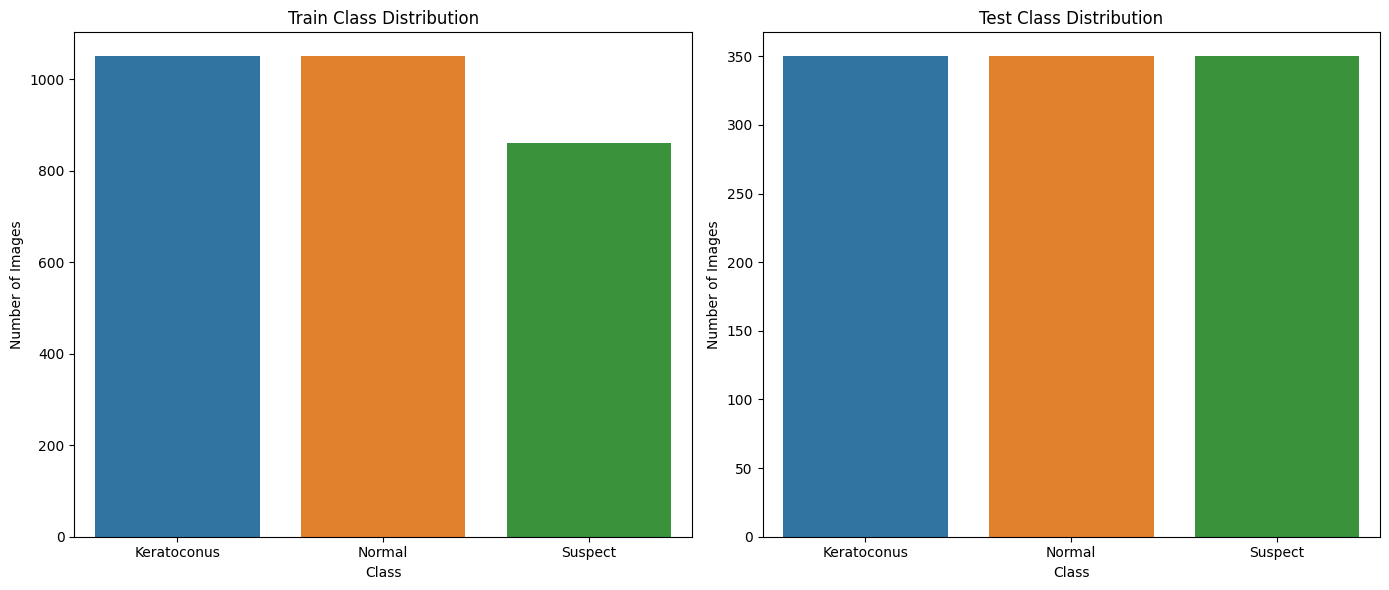

In [4]:
def count_images(folder_path):
    class_counts = {}
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path):
            continue
        total = 0
        for case in os.listdir(cls_path):
            case_path = os.path.join(cls_path, case)
            if os.path.isdir(case_path):
                images = [img for img in os.listdir(case_path) 
                          if img.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff'))]
                total += len(images)
        class_counts[cls] = total
    return class_counts

train_counts = count_images(TRAIN_PATH)
test_counts = count_images(TEST_PATH)

print("\nTrain Image Counts per Class:", train_counts)
print("Test Image Counts per Class:", test_counts)

fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0])
ax[0].set_title('Train Class Distribution')
ax[0].set_ylabel('Number of Images')
ax[0].set_xlabel('Class')

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1])
ax[1].set_title('Test Class Distribution')
ax[1].set_ylabel('Number of Images')
ax[1].set_xlabel('Class')

plt.tight_layout()
plt.show()


# Size Check

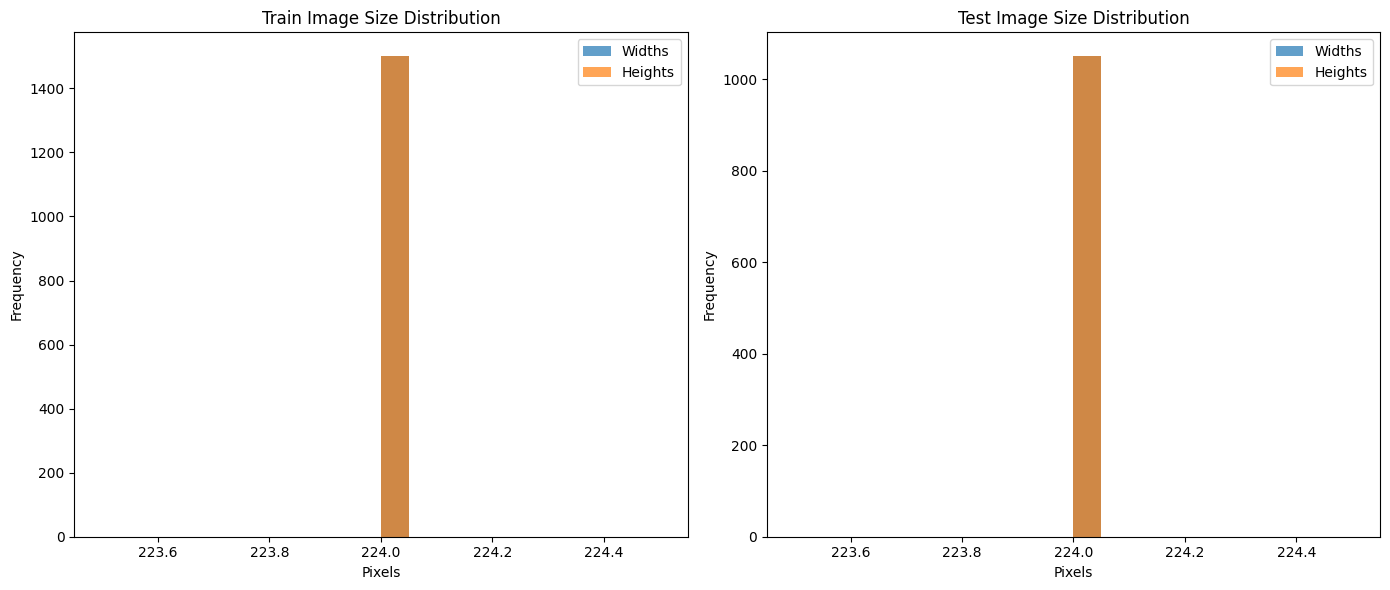

In [5]:
def get_image_shapes(folder_path, sample_size=500):
    shapes = []
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path):
            continue
        cases = os.listdir(cls_path)
        case_paths = [os.path.join(cls_path, case) for case in cases 
                      if os.path.isdir(os.path.join(cls_path, case))]
        
        all_images = []
        for case_folder in case_paths:
            for img_name in os.listdir(case_folder):
                img_path = os.path.join(case_folder, img_name)
                if img_name.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff')):
                    all_images.append(img_path)
        
        sampled_images = random.sample(all_images, min(sample_size, len(all_images)))
        for img_path in sampled_images:
            try:
                with Image.open(img_path) as img:
                    shapes.append(img.size)  # (width, height)
            except Exception as e:
                print(f"Error opening {img_path}: {e}")
    return shapes

train_shapes = get_image_shapes(TRAIN_PATH)
test_shapes = get_image_shapes(TEST_PATH)

train_widths, train_heights = zip(*train_shapes)
test_widths, test_heights = zip(*test_shapes)

# Plotting image size distributions
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(train_widths, bins=20, alpha=0.7, label='Widths')
plt.hist(train_heights, bins=20, alpha=0.7, label='Heights')
plt.title('Train Image Size Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1,2,2)
plt.hist(test_widths, bins=20, alpha=0.7, label='Widths')
plt.hist(test_heights, bins=20, alpha=0.7, label='Heights')
plt.title('Test Image Size Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# Images View

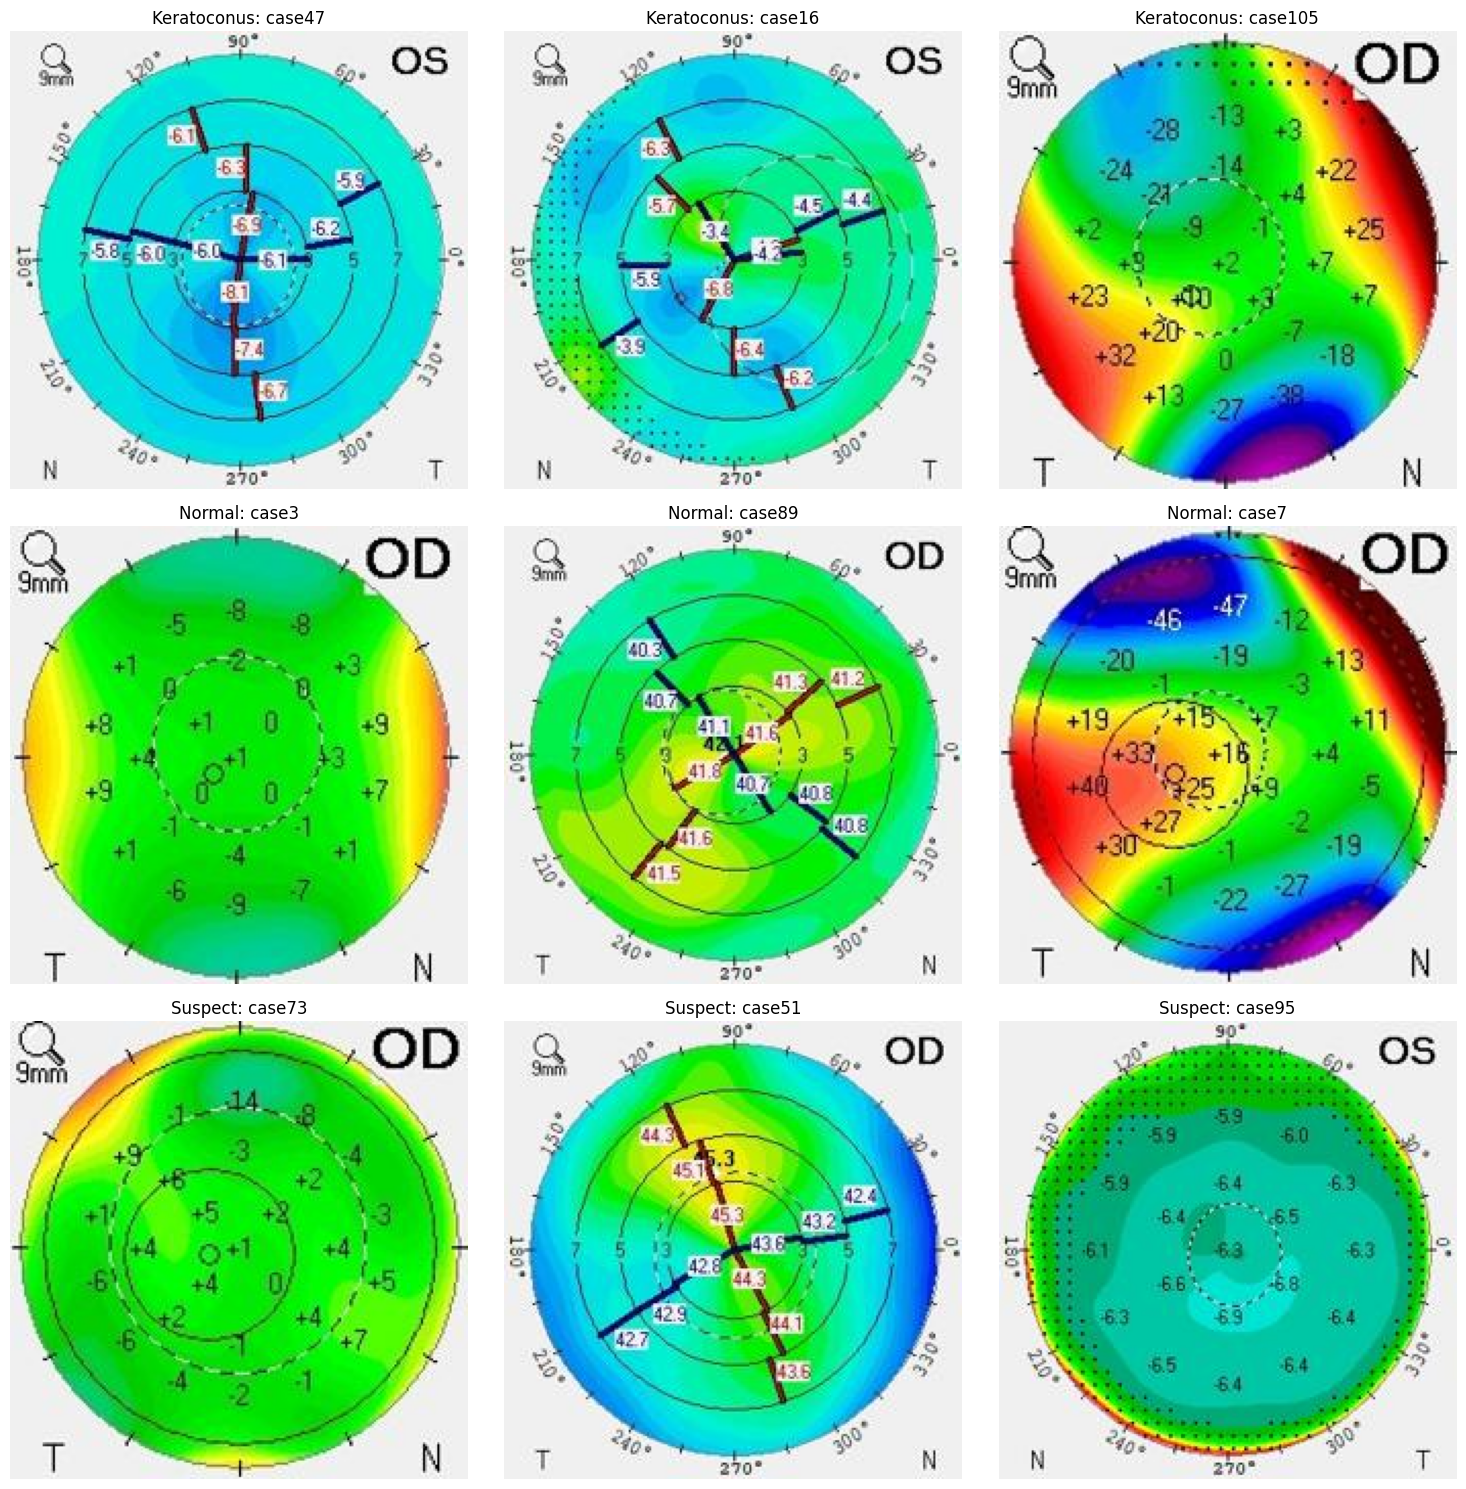

In [6]:

def show_samples(folder_path, n_samples=3):
    classes = os.listdir(folder_path)
    plt.figure(figsize=(15, 5 * len(classes)))
    
    for idx, cls in enumerate(classes):
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path):
            continue
        
        cases = [case for case in os.listdir(cls_path) 
                 if os.path.isdir(os.path.join(cls_path, case))]
        sample_cases = random.sample(cases, min(n_samples, len(cases)))
        
        for i, case in enumerate(sample_cases):
            case_path = os.path.join(cls_path, case)
            imgs = [img for img in os.listdir(case_path) 
                    if img.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff'))]
            if imgs:
                img_path = os.path.join(case_path, random.choice(imgs))
                try:
                    img = Image.open(img_path)
                    plt.subplot(len(classes), n_samples, idx*n_samples + i + 1)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(f'{cls}: {case}')
                except Exception as e:
                    print(f"Could not open image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

show_samples(TRAIN_PATH, n_samples=3)


# Train Validation Split

In [ ]:
root_dir = TRAIN_PATH
train_dir = MOD_DATA_TRAIN
val_dir = MOD_DATA_VAL

val_percentage = 0.3

for class_dir in os.listdir(root_dir):
    
    os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)

    
    for case_dir in os.listdir(os.path.join(root_dir, class_dir)):
        
        image_files = [f for f in os.listdir(os.path.join(root_dir, class_dir, case_dir)) if f.endswith(".jpg")]

        
        random.shuffle(image_files)

        
        val_size = int(len(image_files) * val_percentage)
        train_images = image_files[val_size:]
        val_images = image_files[:val_size]

        if os.path.exists(os.path.join(train_dir, class_dir, case_dir)):
            shutil.rmtree(os.path.join(train_dir, class_dir, case_dir))
        os.mkdir(os.path.join(train_dir, class_dir, case_dir))

        if os.path.exists(os.path.join(val_dir, class_dir, case_dir)):
            shutil.rmtree(os.path.join(val_dir, class_dir, case_dir))
        os.mkdir(os.path.join(val_dir, class_dir, case_dir))
    
        
        for image_file in train_images:
            src_path = os.path.join(root_dir, class_dir, case_dir, image_file)
            dst_path = os.path.join(train_dir, class_dir, case_dir, image_file)
            shutil.copy(src_path, dst_path)

        
        for image_file in val_images:
            src_path = os.path.join(root_dir, class_dir, case_dir, image_file)
            dst_path = os.path.join(val_dir, class_dir, case_dir, image_file)
            # if os.path.exists(os.path.join(val_dir, class_dir, case_dir)):
                # shutil.rmtree(os.path.join(val_dir, class_dir, case_dir))
            # os.mkdir(os.path.join(val_dir, class_dir, case_dir))
            shutil.copy(src_path, dst_path)
print("Train - Validation Split  completed.")

Train - Validation Split  completed.


# Checking Image count after split

Train Set Image Counts: {'Suspect': 615, 'Keratoconus': 750, 'Normal': 750}
Validation Set Image Counts: {'Suspect': 246, 'Keratoconus': 300, 'Normal': 300}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


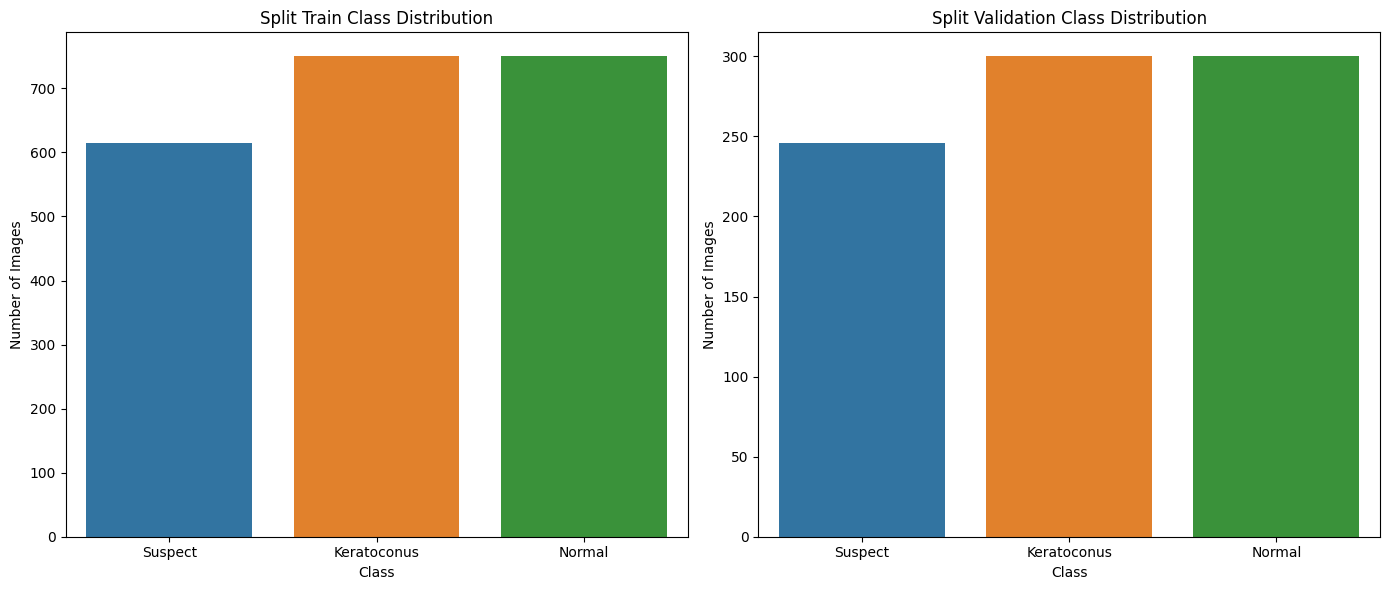

In [8]:

split_train_counts = count_images(train_dir)
split_val_counts = count_images(val_dir)
print("Train Set Image Counts:", split_train_counts)
print("Validation Set Image Counts:", split_val_counts)

fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=list(split_train_counts.keys()), y=list(split_train_counts.values()), ax=ax[0])
ax[0].set_title('Split Train Class Distribution')
ax[0].set_ylabel('Number of Images')
ax[0].set_xlabel('Class')

sns.barplot(x=list(split_val_counts.keys()), y=list(split_val_counts.values()), ax=ax[1])
ax[1].set_title('Split Validation Class Distribution')
ax[1].set_ylabel('Number of Images')
ax[1].set_xlabel('Class')

plt.tight_layout()
plt.show()

# Increasing Suspect Class


In [9]:
import os
import random
import shutil
from PIL import Image
from torchvision import transforms

augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
])

suspect_train_dir = os.path.join(train_dir, 'Suspect')


existing_images = []
for case_folder in os.listdir(suspect_train_dir):
    case_path = os.path.join(suspect_train_dir, case_folder)
    if os.path.isdir(case_path):
        for img_file in os.listdir(case_path):
            if img_file.endswith(".jpg"):
                existing_images.append(os.path.join(case_path, img_file))

target_count = 740
current_count = len(existing_images)
needed = target_count - current_count
print(f"Augmenting {needed} more Suspect images...")

# Start augmentation
save_count = 0
while save_count < needed:
    img_path = random.choice(existing_images)
    img = Image.open(img_path)

    augmented_img = augmentations(img)
    
    save_dir = os.path.dirname(img_path)
    new_filename = f"aug_{save_count}_{os.path.basename(img_path)}"
    augmented_img.save(os.path.join(save_dir, new_filename))
    
    save_count += 1

print("Augmentation completed. Total Suspect training images should now be 740.")


Augmenting 125 more Suspect images...
Augmentation completed. Total Suspect training images should now be 740.


In [ ]:
import os
import random
from PIL import Image
from torchvision import transforms

val_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize((224, 224)),
])


suspect_val_dir = os.path.join(val_dir, 'Suspect')

existing_val_images = []
for case_folder in os.listdir(suspect_val_dir):
    case_path = os.path.join(suspect_val_dir, case_folder)
    if os.path.isdir(case_path):
        for img_file in os.listdir(case_path):
            if img_file.endswith(".jpg"):
                existing_val_images.append(os.path.join(case_path, img_file))

target_val_count = 295
current_val_count = len(existing_val_images)
needed_val = target_val_count - current_val_count
print(f"Augmenting {needed_val} more Suspect images for validation set...")

val_aug_count = 0
while val_aug_count < needed_val:
    img_path = random.choice(existing_val_images)
    img = Image.open(img_path)

    augmented_img = val_augmentations(img)

    save_dir = os.path.dirname(img_path)
    new_filename = f"aug_val_{val_aug_count}_{os.path.basename(img_path)}"
    augmented_img.save(os.path.join(save_dir, new_filename))

    val_aug_count += 1

print("Validation set augmentation completed. Total Suspect validation images should now be 295.")


Augmenting 49 more Suspect images for validation set...
Validation set augmentation completed. Total Suspect validation images should now be 295.


# Image count after suspect class Augmentation

Train Set Image Counts: {'Suspect': 740, 'Keratoconus': 750, 'Normal': 750}
Validation Set Image Counts: {'Suspect': 295, 'Keratoconus': 300, 'Normal': 300}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


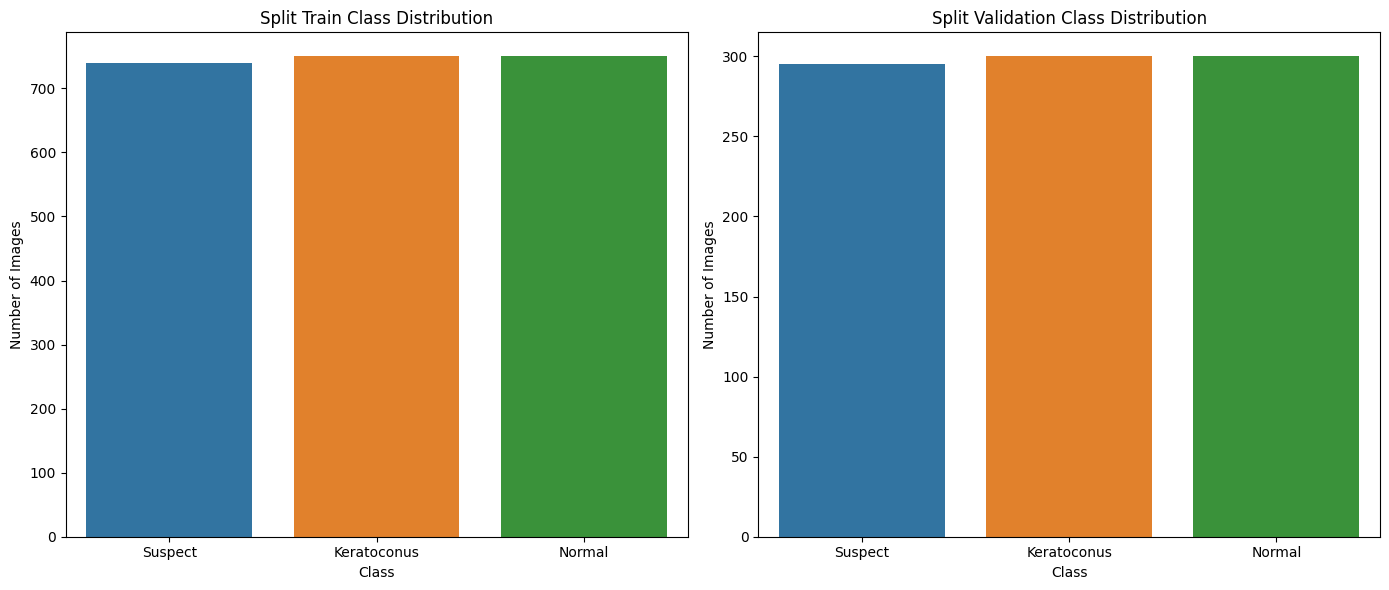

In [11]:

split_train_counts = count_images(train_dir)
split_val_counts = count_images(val_dir)
print("Train Set Image Counts:", split_train_counts)
print("Validation Set Image Counts:", split_val_counts)

fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=list(split_train_counts.keys()), y=list(split_train_counts.values()), ax=ax[0])
ax[0].set_title('Split Train Class Distribution')
ax[0].set_ylabel('Number of Images')
ax[0].set_xlabel('Class')

sns.barplot(x=list(split_val_counts.keys()), y=list(split_val_counts.values()), ax=ax[1])
ax[1].set_title('Split Validation Class Distribution')
ax[1].set_ylabel('Number of Images')
ax[1].set_xlabel('Class')

plt.tight_layout()
plt.show()

# Data Loaders

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)   
BATCH_SIZE = 32

In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 2369 images belonging to 3 classes.
Found 592 images belonging to 3 classes.


In [14]:
x_batch, y_batch = next(train_generator)
print(f"Image batch shape: {x_batch.shape}")
print(f"Label batch shape: {y_batch.shape}")


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


# Model Devlopment

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import regularizers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


input_shape = (224, 224, 3)
class_count = train_generator.num_classes  

# Loading base model
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))

#last 50 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(name='global_avg_pool')(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, name='batch_norm_x')(x)
x = Dense(
    1024,
    kernel_regularizer=regularizers.l2(0.001),
    activity_regularizer=regularizers.l1(0.001),
    bias_regularizer=regularizers.l1(0.001),
    activation='relu',
    name='dense_x'
)(x)
x = Dropout(rate=0.3, seed=123, name='dropout_x')(x)
x = Dense(512, activation='relu', name='dense_512')(x)
x = Dropout(0.3, name='dropout_512')(x)
output = Dense(class_count, activation='softmax', name='dense_output')(x)


model = Model(inputs=base_model.input, outputs=output)
model.summary()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1746781047.464443      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,220,419 (100.02 MB)

 Trainable params: 19,579,139 (74.69 MB)

 Non-trainable params: 6,641,280 (25.33 MB)

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)


# Model Training

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746781079.426441      75 service.cc:148] XLA service 0x7e60c0002720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746781079.427101      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746781081.853498      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/75 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.3984 - loss: 17.7012  

I0000 00:00:1746781092.437081      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5496 - loss: 12.4428
Epoch 1: val_loss improved from inf to 17.43912, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 362ms/step - accuracy: 0.5502 - loss: 12.3952 - val_accuracy: 0.5017 - val_loss: 17.4391 - learning_rate: 1.0000e-04
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6396 - loss: 3.9991
Epoch 2: val_loss improved from 17.43912 to 8.95905, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.6398 - loss: 3.9950 - val_accuracy: 0.6706 - val_loss: 8.9590 - learning_rate: 1.0000e-04
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6774 - loss: 3.0220
Epoch 3: val_loss improved from 8.95905 to 4.31743, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.6773 - loss: 3.0207 - val_accuracy: 0.7297 - val_loss: 4.3174 - learning_rate: 1.0000e-04
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy

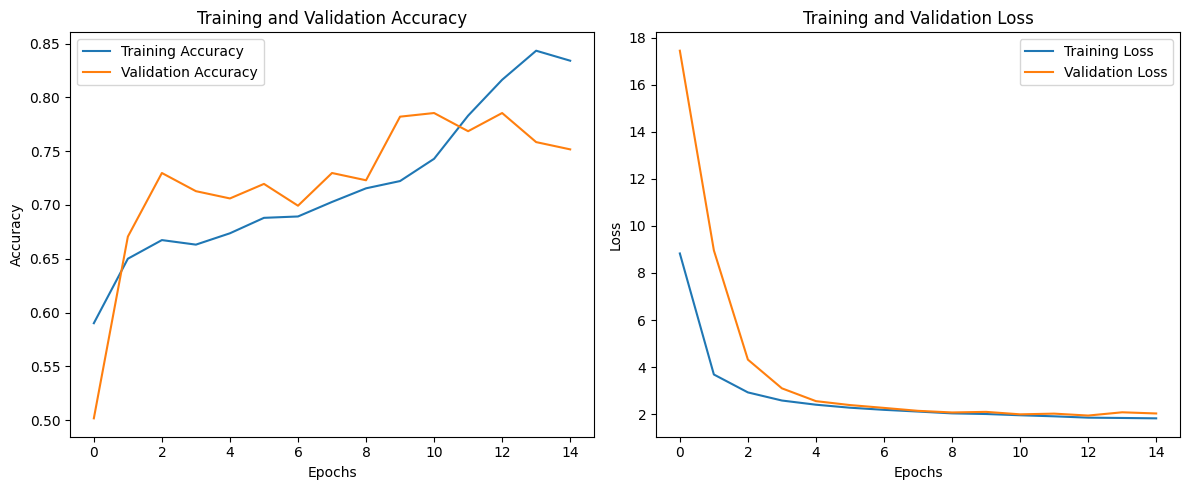

In [18]:
import matplotlib.pyplot as plt

# Extracting the values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plotting Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Confusion Matrix:
[[201   3   6]
 [  1 174  35]
 [ 29  53  90]]


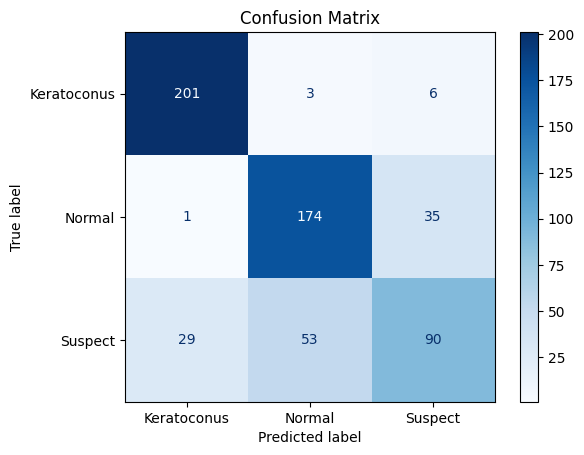

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


y_true = []
y_pred = []

for X_batch, y_batch in val_generator:
    preds = model.predict(X_batch)

    y_true.extend(np.argmax(y_batch, axis=1))         
    y_pred.extend(np.argmax(preds, axis=1))          

    if len(y_true) >= val_generator.samples:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

class_names = val_generator.class_indices 
class_names = list(class_names.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [20]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

 Keratoconus       0.87      0.96      0.91       210
      Normal       0.76      0.83      0.79       210
     Suspect       0.69      0.52      0.59       172

    accuracy                           0.79       592
   macro avg       0.77      0.77      0.77       592
weighted avg       0.78      0.79      0.78       592



# Testing

In [21]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1050 images belonging to 3 classes.


 1/33 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7188 - loss: 2.1255

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.6160 - loss: 2.2523

Test accuracy: 59.05%
Test loss: 2.2298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━

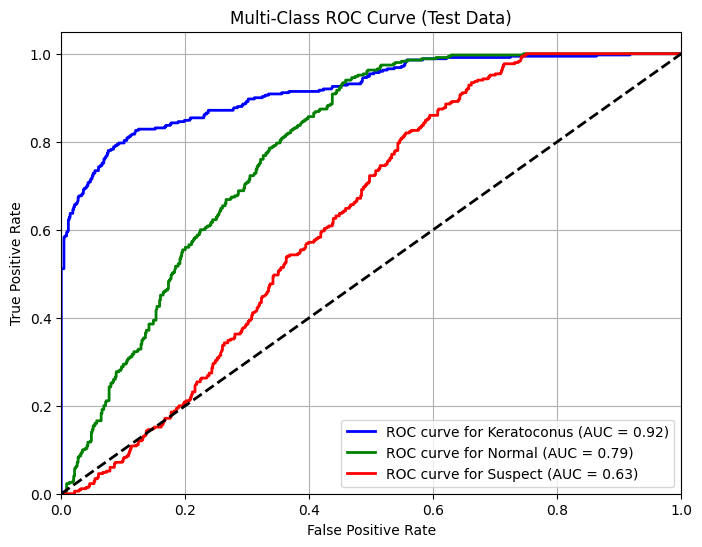

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'\nTest accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

y_true = []
y_pred_prob = []

for X_batch, y_batch in test_generator:
    preds = model.predict(X_batch)
    y_pred_prob.extend(preds)                      
    y_true.extend(y_batch)                         

    if len(y_true) >= test_generator.samples:
        break

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
class_names = list(test_generator.class_indices.keys())

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Test Data)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
print(confusion_matrix(y_true, y_pred))


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step
              precision    recall  f1-score   support

 Keratoconus       0.94      0.65      0.77       350
      Normal       0.58      0.51      0.54       350
     Suspect       0.43      0.62      0.50       350

    accuracy                           0.59      1050
   macro avg       0.65      0.59      0.60      1050
weighted avg       0.65      0.59      0.60      1050

[[227   5 118]
 [  1 177 172]
 [ 13 121 216]]


# Vizualizing Correct and Wrong Predictions

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


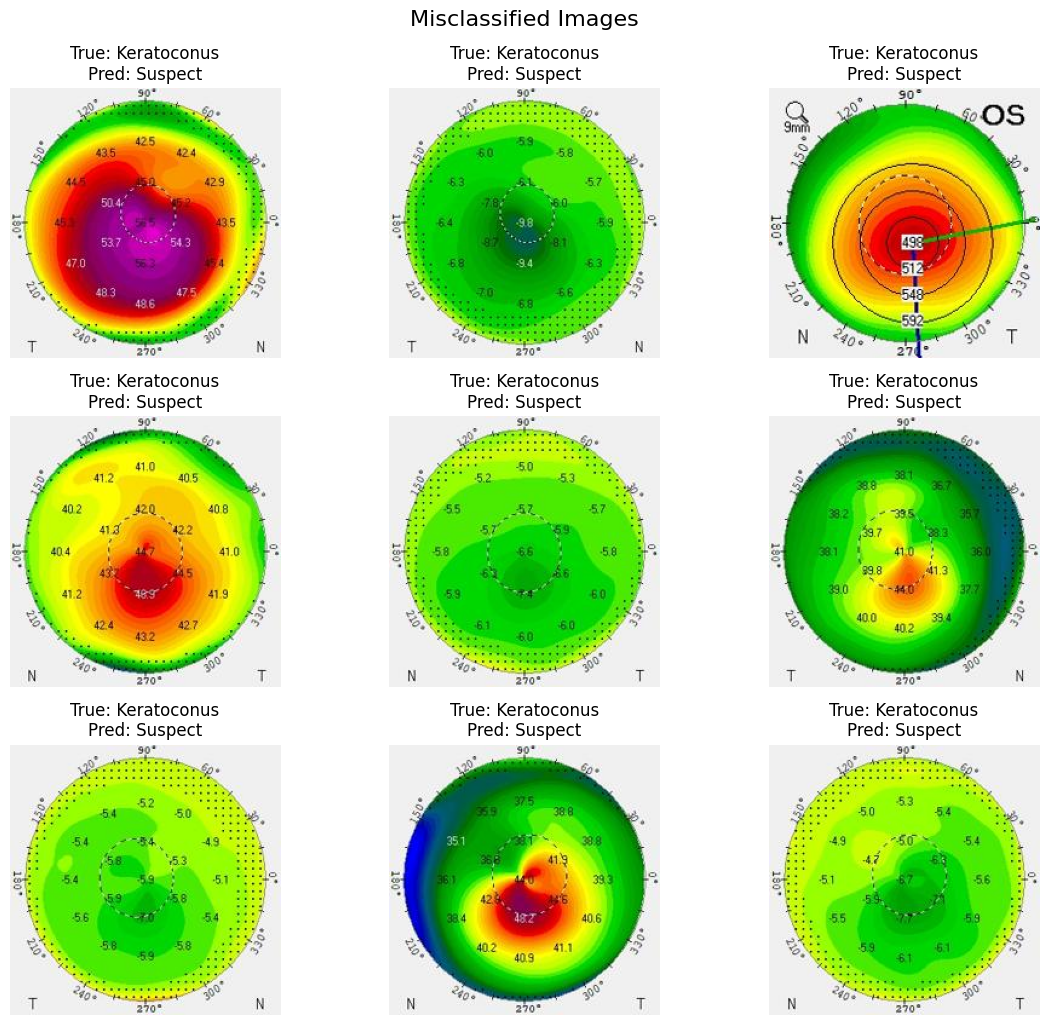

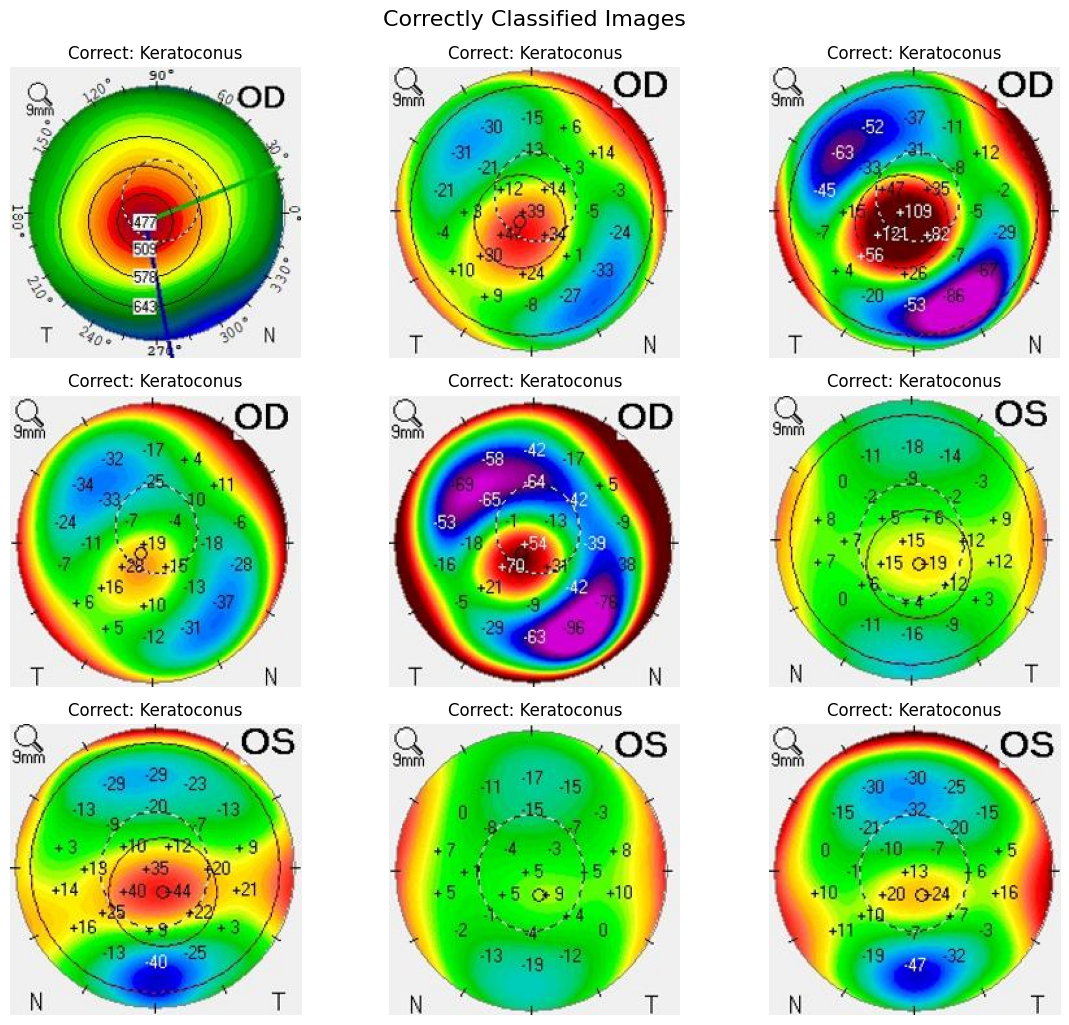

In [24]:
import matplotlib.pyplot as plt
import numpy as np

class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes
filenames = test_generator.filenames

#Misclassified Images
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = min(9, len(misclassified_indices))

plt.figure(figsize=(12, 10))
for i in range(num_misclassified):
    idx = misclassified_indices[i]
    img = plt.imread(test_generator.filepaths[idx])
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {idx_to_class[y_true[idx]]}\nPred: {idx_to_class[y_pred[idx]]}")
plt.tight_layout()
plt.suptitle("Misclassified Images", fontsize=16, y=1.02)
plt.show()
#Correct Predictions
correct_indices = np.where(y_pred == y_true)[0]
num_correct = min(9, len(correct_indices))

plt.figure(figsize=(12, 10))
for i in range(num_correct):
    idx = correct_indices[i]
    img = plt.imread(test_generator.filepaths[idx])
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Correct: {idx_to_class[y_true[idx]]}")
plt.tight_layout()
plt.suptitle("Correctly Classified Images", fontsize=16, y=1.02)
plt.show()
